In [14]:
import torch
import cv2
import numpy as np

In [15]:
import torch.nn.functional as F
#@staticmethod
def unwarp_image(img, bm):
    assert bm.shape[3] == 2, "BM shape needs to be (N, H, W, C)"
    
    n, c, h, w = img.shape

    bm = bm.transpose(3, 2).transpose(2, 1)
    bm = F.interpolate(bm, size=(h, w), mode='bilinear', align_corners=True) # align_corners=True -> old behaviour
    bm = bm.transpose(1, 2).transpose(2, 3)

    bm = 2 * bm - 1 # adapt value range for grid_sample
    bm = bm.transpose(1, 2) # rotate image by 90 degrees (NOTE: this transformation might be deleted in future BM versions)
    
    img = img.float()
    res = F.grid_sample(input=img, grid=bm, align_corners=True) # align_corners=True -> old behaviour
    res = torch.clamp(res, 0, 1) # clip values because of numerical instabilities
    return res

In [16]:
import numpy as np

data_path = 'Dataset Preview/Inv3D preview complete V2/data/train/08'

img = cv2.imread(data_path + '/warped_document.png')
#img = dataset_train.transform_img(img)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)#.transpose(2,3).transpose
img = img / 255
print(img.shape)

torch.Size([1, 3, 256, 256])


In [17]:
warped_bm = np.load(data_path + '/warped_BM.npz')['warped_BM']
warped_bm = torch.from_numpy(warped_bm).float()
warped_bm = warped_bm.unsqueeze(0)
warped_bm.shape

torch.Size([1, 256, 256, 2])

In [18]:
unwarped_img = unwarp_image(img, warped_bm)
unwarped_img =  unwarped_img.transpose(1,2).transpose(2,3)
unwarped_img.shape

torch.Size([1, 256, 256, 3])

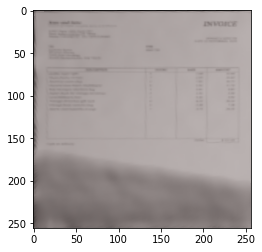

In [19]:
import matplotlib.pyplot as plt
plt.imshow(unwarped_img.numpy()[0])

In [1]:

import pytorch_lightning as pl
from models.densenetccnl import Backwardmapper
DATA_PATH = 'Dataset Preview/Inv3D preview complete V2/data/'
data_dir= 'Dataset Preview/Inv3D preview complete V2/data/train/'


from custom_dataset import CustomImageDataset_wc
dataset_train = CustomImageDataset_wc(data_dir=DATA_PATH+'train/', transform=True)
dataset_val = CustomImageDataset_wc(data_dir=DATA_PATH+'val/', transform=True)
dataset_test = CustomImageDataset_wc(data_dir=DATA_PATH+'test/', transform=True)

from custom_dataset import Dataset_backward_mapping
train_dataset_bm = Dataset_backward_mapping(data_dir=DATA_PATH+'train/')



from torch.utils.data import DataLoader
train_loader_bm = DataLoader(train_dataset_bm, batch_size=1, num_workers=8, shuffle=True)

train_loader = DataLoader(dataset_train, batch_size= 1, num_workers=12)
val_loader = DataLoader(dataset_val, batch_size= 1, num_workers=12)
test_loader = DataLoader(dataset_test, batch_size= 1, num_workers=12)

from models import unetnc
model = unetnc.Estimator3d(input_nc=3, output_nc=3, num_downs=0)
model_bm = Backwardmapper()

#8 channel


# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
trainer = pl.Trainer(gpus=1, max_epochs = 20)
#trainer = pl.Trainer(auto_select_gpus = True, max_epochs = 100)
#trainer.fit(model, train_loader)

# Wie sieht der Batch aus, der vom trainer und train_loader generiert wird?

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [2]:
trainer.fit(model_bm, train_loader_bm)
#CustomImageDataset_wc.calculate_min_and_max(data_dir)
#for batch in train_loader_bm:
 #   images, labels = batch

/home/leon/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params
------------------------------------------------
0 | encoder | waspDenseEncoder128 | 21.9 M
1 | decoder | waspDenseDecoder128 | 23.8 M
------------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.997   Total estimated model params size (MB)
Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

RuntimeError: grid_sampler(): expected grid and input to have same batch size, but got input with sizes [4, 2, 256, 256] and grid with sizes [1, 256, 256, 2]

In [1]:
import angles
import torch
import numpy as np

data_path = 'Dataset Preview/Inv3D preview complete V2/data/train/08'

In [2]:
def transform_labels(labels):
    for label in labels:

        lbl = labels[label]
        lbl = lbl.transpose(2, 0, 1)   # NHWC -> NCHW
        lbl = np.array(lbl, dtype=np.float64)
        lbl = torch.from_numpy(lbl).float()
        lbl = lbl.unsqueeze(0)
        labels[label] = lbl

    return labels

In [3]:

labels = {}
labels['warped_bm'] = np.load(data_path + '/warped_BM.npz')['warped_BM']
labels['warped_uv'] = np.load(data_path + '/warped_UV.npz')['warped_UV']
labels['warped_angle'] = np.load(data_path + '/warped_angle.npz')['warped_angle']
labels = transform_labels(labels)

In [11]:
angles_map = angles.calc_angles_torch(labels['warped_bm'].transpose(1,2).transpose(2,3))
warped_angle = angles.warp_grid_torch(angles_map, labels['warped_uv'].transpose(1,2).transpose(2,3)).transpose(3,2).transpose(2,1)

In [5]:
labels['warped_bm'].shape

torch.Size([1, 2, 256, 256])

In [6]:
labels['warped_uv'].shape

torch.Size([1, 3, 256, 256])

In [7]:
labels['warped_angle'].shape

torch.Size([1, 2, 256, 256])

In [13]:
torch.sum(warped_angle - labels['warped_angle'])

tensor(-840.6662)

In [10]:
warped_angle.shape

torch.Size([1, 256, 256, 2])